In [4]:
import torch
import numpy as np
import math
from gdstxtgen import *

gdsfile = "GS_nk_sinx_N2_23h=810_p=400_r=1.txt"; num = 700; ff='GS'
# gdsfile = "e2e_gds_r=1.txt"; num = 1000; ff='E2E'
p = 400
ar = p * np.linspace(-num/2, num/2 - 1, num)
xv, yv = np.meshgrid(ar, ar[::-1])

lw_ar = np.zeros((num, num, 2))
n_ar = np.ones((num, num))
rot_ar = np.zeros((num, num))

idx = 0
ph_step = 2 * np.pi / 6 # Wrong value

num_line = 0
pillar_order = 1         
            
with open(gdsfile, "r") as f:
    for start_idx in range(9):
        f.readline()
    while True:
        num_line += 1
        l0 = f.readline()            # 'XY\n'
        if l0 == "": break
        
        # 1st Coordinate
        l1 = f.readline()
        # [x1, y1] = [int(i) for i in l1.strip().split('\t:\t')]
        try:
            [x1, y1] = [int(i) for i in l1.strip().split('\t:\t')]
        except ValueError:
            print(num_line)
        # 2nd Coordinate
        l2 = f.readline()
        # [x2, y2] = [int(i) for i in l2.strip().split('\t:\t')]
        try:
            [x2, y2] = [int(i) for i in l2.strip().split('\t:\t')]
        except ValueError:
            print(num_line)
                
        # 3rd Coordinate
        l3 = f.readline()
        [x3, y3] = [int(i) for i in l3.strip().split('\t:\t')]
        
        # Get theta, l, w
        try:
            theta = math.atan((y2-y1) / (x2-x1))
            if theta < 0:
                theta += math.pi
                w = np.abs((x1 - x2) / np.cos(theta))
                l = np.abs((y2 - y3) / np.cos(theta))
            elif theta == 0:
                if x1 < x2:
                    theta = math.pi
                    w = np.abs(x2 - x1)
                    l = np.abs(y3 - y2)
                else: 
                    w = np.abs(x1 - x2)
                    l = np.abs(y2 - y3)
            else:
                w = np.abs((x1 - x2) / np.cos(theta))
                l = np.abs((y2 - y3) / np.cos(theta))
                    
        except ZeroDivisionError:
            theta = math.pi/2
            l = np.abs(x1 - x2)
            w = np.abs(y2 - y3)

        l = round(max(l, 40), -1); w = round(max(w, 40), -1)
        
        # Get the center of the pillar
        idx_x = idx // num; idx_y = idx % num
        x_o, y_o = xv[idx_y, idx_x], yv[idx_y, idx_x] 
        
        # Update index
        if (x1 + x3) /2 == x_o:
            # Pillar num:1 & first/last
            if pillar_order == 1:   
                lw_ar[idx_y, idx_x, :] = [l, w]
                rot_ar[idx_y, idx_x] = round(theta / ph_step)
                idx += 1
                
            # Pillar num:3 & second
            elif pillar_order == 2: 
                pillar_order = 3
            else:
                raise ValueError('Pillar order is wrong')
        else:           
            # Pillar num:2,3 & first
            if pillar_order == 1:   
                lw_ar[idx_y, idx_x, :] = [l, w]
                rot_ar[idx_y, idx_x] = round(theta / ph_step)
                pillar_order = 2
            
            # Pillar num:2 & last
            elif pillar_order == 2: 
                n_ar[idx_y, idx_x] = 2
                idx += 1
                pillar_order = 1    # Reset pillar order
            
            # Pillar num:3 & last
            elif pillar_order == 3: 
                n_ar[idx_y, idx_x] = 3
                idx += 1
                pillar_order = 1    # Reset pillar order
        
        for end_idx in range(6): # '4~5th lines', 'ENDEL', 'BOUNDARY', 'LAYER 46', 'DATATYPE 46';
            f.readline()

lw_2d = lw_ar; numP = n_ar; theta = rot_ar
numP_2d = numP; rot_2d = theta 

# gdstxtgen(ff, rot_2d.T, p, ratio=1, version='lw_array', lw=np.transpose(lw_2d, (1, 0, 2)), numP=numP_2d.T)

In [5]:
lwn_ar = np.concatenate([lw_ar, n_ar[:, :, np.newaxis]], axis=2)
lwn_1d = lwn_ar.reshape(-1, 3)

import matplotlib.pyplot as plt
import numpy as np
import torch
from fwdnet.jbnet import *

def norm(unnorm_tensor, target, device):
    unnorm_tensor = unnorm_tensor.to(dtype=torch.float32, device=device)
    data_dir = './fwdnet/gen_20240611/preprocessed/'
    mean = torch.load(data_dir + target + '_mean.pt').to(dtype=torch.float32, device=device)
    std = torch.load(data_dir + target + '_std.pt').to(dtype=torch.float32, device=device)
    norm_tensor = (unnorm_tensor - mean) / (std + 1e-10)
    return norm_tensor

class UniqueWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A):
        # Use numpy to find unique rows, but we'll also need to track which rows were selected
        unique, inverse_indices = torch.unique(A, dim=0, return_inverse=True)
        ctx.save_for_backward(inverse_indices, torch.tensor(A.shape, device=A.device))
        return unique, inverse_indices

    @staticmethod
    def backward(ctx, grad_unique, grad_inverse_indices):
        inverse_indices, original_shape = ctx.saved_tensors
                
        # Expand grad_unique to match the dimensions of the input tensor
        grad_expanded = grad_unique[inverse_indices]

        return grad_expanded, None

def unique_with_grad(A):
    return UniqueWithGrad.apply(A)

def run_extract(fwd_input, net, numX, device):
    def c_intp_mag(x1, x2, x_mid, y1, y2):
        return y1 + (y2 - y1) / (x2 - x1) * (x_mid - x1)
             
    def c_intp_phase(x1, x2, x_mid, ar_y1, ar_y2):
        y_mid = torch.zeros_like(ar_y1, device=device)
        for i, (y1, y2) in enumerate(zip(ar_y1, ar_y2)):
            if y1 * y2 >= 0:
                y_mid[i] = y1 + (y2 - y1) / (x2 - x1) * (x_mid - x1)
            elif y1 < y2: # y1 < 0 < y2
                y_minus = y1 + 2; y_plus = y2; x_minus = x1; x_plus = x2
                y_mid[i] =  y_minus + (y_plus - y_minus) / (x_plus - x_minus) * (x_mid - x_minus)
            elif y2 < y1: # y2 < 0 < y1
                y_minus = y2 + 2; y_plus = y1; x_minus = x2; x_plus = x1
                y_mid[i] =  y_minus + (y_plus - y_minus) / (x_plus - x_minus) * (x_mid - x_minus)
        y_mid[y_mid > 1] -= 2
        return y_mid 
    
    def txy_to_tmp(tx, ty):
        tm = tx ** 2 + ty ** 2
        epsilon = 1e-10
        safe_tx = tx + epsilon * torch.sign(tx)
        tp = torch.atan(ty / (safe_tx)) / torch.pi \
        - torch.logical_and(tx < 0, ty < 0).type(torch.float32) \
        + torch.logical_and(tx < 0, ty > 0).type(torch.float32)
        return tm, tp
    
    wl = [473, 532, 635]
    num_wl = len(wl)

    u_fwd_input, inverse_indices = unique_with_grad(fwd_input)
    u_fwd_output = net(u_fwd_input)
    u_tm = torch.zeros([u_fwd_output.shape[0], num_wl], device=device)
    u_tp = torch.zeros([u_fwd_output.shape[0], num_wl], device=device)
    for i in range(num_wl):
        x_i1 = (wl[i] // 10) * 10; x_i2 = x_i1 + 10
        idx_i1 = (x_i1 - 400) // 10; idx_i2 = idx_i1 + 1
        tm_i1, tp_i1 = txy_to_tmp(u_fwd_output[:, idx_i1, 0], u_fwd_output[:, idx_i1, 1])
        tm_i2, tp_i2 = txy_to_tmp(u_fwd_output[:, idx_i2, 0], u_fwd_output[:, idx_i2, 1])
        u_tm[:, i] = c_intp_mag(x_i1, x_i2, wl[i], tm_i1, tm_i2)
        u_tp[:, i] = c_intp_phase(x_i1, x_i2, wl[i], tp_i1, tp_i2)
    
    # Map u_tm to tm
    tm = u_tm[inverse_indices]
    tp = u_tp[inverse_indices]
    tm_reshaped     = tm.view(numX, numX, num_wl)
    tp_reshaped     = tp.view(numX, numX, num_wl)
    return tm_reshaped, tp_reshaped

# Nk list
nk_f = './fwdnet/nk_data/202307/nk_interpolated-npy/nk_sinx_N2_23.npy'
nk_selected = torch.from_numpy(np.load(nk_f))

h = 810; p=400
hp = torch.from_numpy(np.array([h, p])).to(torch.float32)


# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Elongate the input
nk_elong = torch.tile(nk_selected, dims=(lwn_1d.shape[0], 1, 1))

h_elong = torch.tile(hp[0].view(1, 1, 1), dims=(lwn_1d.shape[0], 31, 1))
p_elong = torch.tile(hp[1].view(1, 1, 1), dims=(lwn_1d.shape[0], 31, 1))

lwn_elong = torch.tile(torch.from_numpy(lwn_1d).view(-1, 1, 3), dims=(1, 31, 1))
geom_elong = torch.concat([lwn_elong[:, :, 2].unsqueeze(2), \
                                h_elong, p_elong, lwn_elong[:, :, 0:2]], dim=2)
# Normalize the input
nk_norm = nk_elong.to(dtype=torch.float32, device=device)
# nk_norm = norm(nk_elong, 'NK', device)
geom_norm = norm(geom_elong, 'Geom', device)
fwd_input = torch.concat([nk_norm, geom_norm], dim=2)

# Load the trained model
fwd_path = "./fwdnet/net/240702/LSTM_TxyR_lr_0.0014430071317276792_bsize_100_init_H_N_fc_feature_layer_100_300_500_500_hid_size_500_nlayer_3/MSE=0.000878.pt"
checkpoint = torch.load(fwd_path) 
fwdnet_file = fwd_path.split('/')[-2]
init = fwdnet_file.split('init_')[1][:3]   
hs = int(fwdnet_file.split('hid_size_')[1].split('_nlayer')[0])
channels = [int(i) for i in fwdnet_file.split('fc_feature_layer_')[1].split('_hid_size')[0].split('_')]
nl = int(fwdnet_file.split('_nlayer_')[1])
fc_layers = [{'in_channels': channels[i], 'out_channels': channels[i+1]} for i in range(len(channels)-1)]
model_args = {'init': init,
              'input_size': 7,
              'hidden_size': hs,
              'num_layer': nl,
              'fc_feature_layer': fc_layers}
net = LSTM(**model_args, device=device)
if fwd_path.find("TxyR") == -1:
    net.build_fc_layer(input_dim=7, output_dim=2)
else:
    net.build_fc_layer(input_dim=7, output_dim=3)
net.load_state_dict(checkpoint['network'])
net.to(device)
net.eval()

tm, tp = run_extract(fwd_input, net, num, device)
tm_np = tm.cpu().detach().numpy()
tp_np = tp.cpu().detach().numpy() * np.pi + rot_ar.reshape(num, num, 1) * (2 * np.pi / 6)

Conversion efficiency of data/202307/
B: 34.69%, G: 40.14%, R: 68.85%


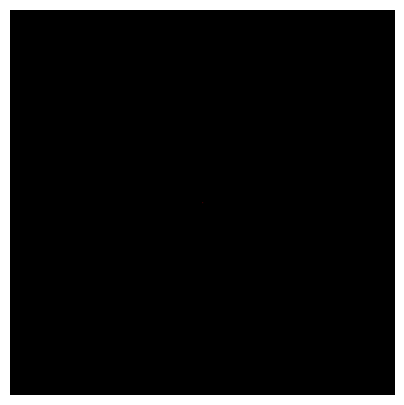

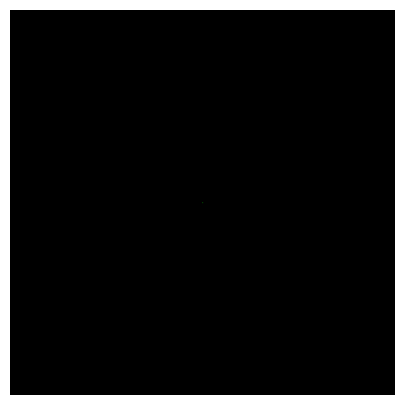

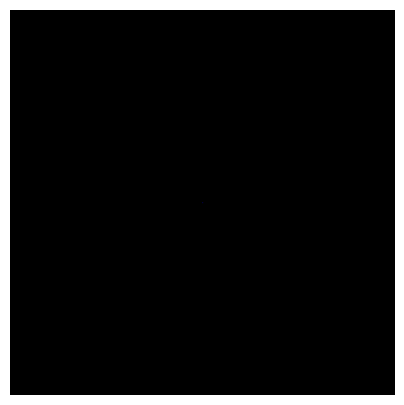

In [6]:
def visualize_hologram(phase, mag):
    # hologram visualization
    I_rgb = np.zeros((phase.shape[0], phase.shape[1], 3))
    for i in range(3):        
        phase_i = phase[:,:,i]
        mag_i = mag[:,:,i]
        efield = mag_i * np.exp(1j*phase_i)
        # Simulation of hologram image using GS algorithm
        I_test = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(efield)))  # forward propagation
        I_test_norm = (np.abs(I_test) ** 2) / np.max(np.abs(I_test) ** 2)  # normalization
        I_rgb[:, :, i] = I_test_norm
    return I_rgb

epsilon = 1e-8
tE = np.sqrt(tm_np * 1.45 + epsilon)
I = visualize_hologram(tp_np, tE)

c_eff = np.mean(tE, axis=(0, 1))
name_mat = nk_f.split('nk_')[1].split('_h')[0]
print(f'Conversion efficiency of {name_mat}')
print(f'B: {100 * c_eff[0]:.2f}%, G: {100 * c_eff[1]:.2f}%, R: {100 * c_eff[2]:.2f}%')

# Display holograms
figsize=(5, 5)
for i in range(3):
    fig, ax = plt.subplots(figsize=figsize)
    I_i = np.zeros_like(I)
    I_i[:, :, i] = I[:, :, 2-i]
    fig.patch.set_visible(False)
    ax.axis('off')
    plt.imshow(I_i)